In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Prefernece of plot style:
plt.style.use('dark_background')

In [2]:
def radial_velocity_model(t: np.array, K: float, P: float, t0: float = 0.0) -> np.array:
    """
    Calculates the radial velocity of a star due to an orbiting planet.
    Assumes a circular orbit (eccentricity e=0).
    
    Formula: v(t) = -K * sin(2 * pi * (t - t0) / P)
    (Note: The negative sign is convention for phase, but K is the amplitude)
    
    Args:
        t (np.array): Time points (days).
        K (float): Velocity semi-amplitude (m/s).
        P (float): Orbital period (days).
        t0 (float): Time of transit/zero-phase (days).
        
    Returns:
        np.array: Radial velocity at each time point (m/s).
    """
    phase = 2 * np.pi * (t - t0) / P
    return -K * np.sin(phase)

In [3]:
# 1. Defining the System Parameters
# Let's simulate a "Hot Jupiter" similar to 51 Pegasi b
P_planet = 4.23       # Period (days)
K_star = 56.0         # Semi-amplitude (m/s) - This is how fast the star wobbles
noise_level = 10.0    # Instrument precision (m/s) - Typical for older spectrographs

In [4]:
# 2. Generate Data
# A. What the star is actually doing

t_model = np.linspace(0,14,500)
v_model = radial_velocity_model(t_model, K_star, P_planet)

# B. The observations (under the telescope)
# For this case, I just pick 20 random nights
np.random.seed(42)
t_obs = np.sort(np.random.uniform(0,14,20))

# Calculate the true velocity at specific times
v_true_at_obs = radial_velocity_model(t_obs, K_star, P_planet)

# Add Gaussian noise (simulating instrument errors and atmosphere)
measurement_error = np.random.normal(0, noise_level, size=len(t_obs))
v_obs = v_true_at_obs + measurement_error

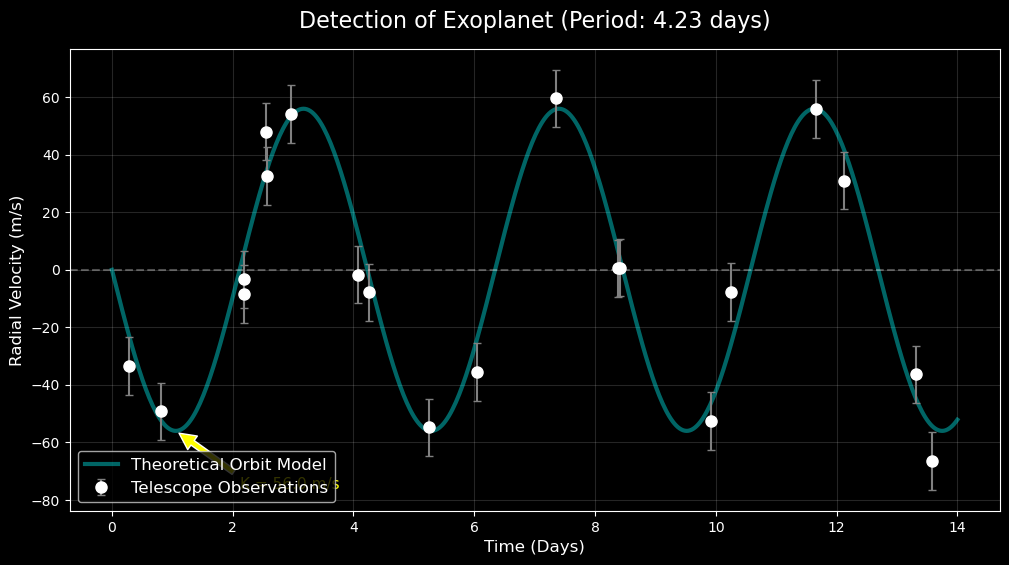

In [5]:
# 3. Visualizations

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the theoretical model (The underlying truth)
ax.plot(t_model, v_model, color='cyan', alpha=0.4, lw=3, label='Theoretical Orbit Model')

# Plot the simulated telescope data
ax.errorbar(t_obs, v_obs, yerr=noise_level, fmt='o', color='white', ecolor='gray', 
            capsize=3, markersize=8, label='Telescope Observations')

# Formatting for publication quality
ax.set_title(f"Detection of Exoplanet (Period: {P_planet} days)", fontsize=16, pad=15)
ax.set_xlabel("Time (Days)", fontsize=12)
ax.set_ylabel("Radial Velocity (m/s)", fontsize=12)
ax.axhline(0, color='white', linestyle='--', alpha=0.3) # Zero velocity line
ax.legend(fontsize=12)
ax.grid(True, alpha=0.15)

# Highlight the Physics
# Annotate the amplitude K
ax.annotate(f'K = {K_star} m/s', 
            xy=(P_planet * 0.25, -K_star), 
            xytext=(P_planet * 0.5, -K_star - 20),
            arrowprops=dict(facecolor='yellow', shrink=0.05),
            color='yellow', fontsize=11)

plt.show()

In [6]:
# 4. Astrophysical Analysis

print("System Properties")
print(f"Observed Period: {P_planet} days")
print(f"Star Wobble Speed (K): {K_star} m/s")

# Challenge: Calculate the Minimum Mass of the Planet
# Formula: M_p * sin(i) approx (P/2piG)^(1/3) * K * M_star^(2/3)
# Let's assume a Solar-type star (M_star = 2e30 kg) and standard constants.

G = 6.674e-11
M_star = 1.989e30
P_seconds = P_planet * 86400

# Simplification for M_planet << M_star
term1 = (P_seconds * G / (2 * np.pi))**(1/3)
m_planet_sini = (term1 * K_star * M_star**(2/3))

mjup = 1.898e27 # Mass of Jupiter in kg
print(f"\nCalculated Minimum Mass: {m_planet_sini:.2e} kg")
print(f"In Jupiter Masses: {m_planet_sini / mjup:.3f} M_Jup")

System Properties
Observed Period: 4.23 days
Star Wobble Speed (K): 56.0 m/s

Calculated Minimum Mass: 1.39e+20 kg
In Jupiter Masses: 0.000 M_Jup


In [7]:
# 5. The Data Science Approach: Model Fitting
from scipy.optimize import curve_fit

In [8]:
# 1. Define the "Hypothesis Function" (The shape of the model)
# We need to make it general so the AI can tune the parameters.
def model_function(t, K_guess, P_guess, phase_guess):
    return -K_guess * np.sin(2 * np.pi * t / P_guess + phase_guess)

In [9]:
# 2. provide Initial Guesses (Hyperparameters)
# Optimization algorithms need a starting point. 
# In a real search, we'd use a Periodogram to find P_guess first.
p0_guess = [50.0, 4.0, 0.0]  # Guess: K=50 m/s, Period=4 days, Phase=0

In [10]:
# 3. Train the Model (Fit the curve)
# curve_fit finds the parameters that minimize the squared error (Loss)
best_params, covariance_matrix = curve_fit(
    model_function, 
    t_obs,       # The Input Features (Time)
    v_obs,       # The Target Labels (Noisy Velocity)
    p0=p0_guess, # Starting point
    sigma=np.full(len(v_obs), noise_level) # Weight data by uncertainty
)

# Extract the "Learned" Parameters
K_fit, P_fit, phase_fit = best_params

In [11]:
# 4. Evaluate the Performance
print(" Machine Learning Results")
print(f"True K: {K_star:.2f} m/s | Learned K: {K_fit:.2f} m/s")
print(f"True P: {P_planet:.2f} days | Learned P: {P_fit:.2f} days")

# Calculate the Standard Deviation (Error bars on our prediction)
errors = np.sqrt(np.diag(covariance_matrix))
print(f"Uncertainty in K: ±{errors[0]:.2f} m/s")

 Machine Learning Results
True K: 56.00 m/s | Learned K: 57.30 m/s
True P: 4.23 days | Learned P: 4.19 days
Uncertainty in K: ±3.46 m/s


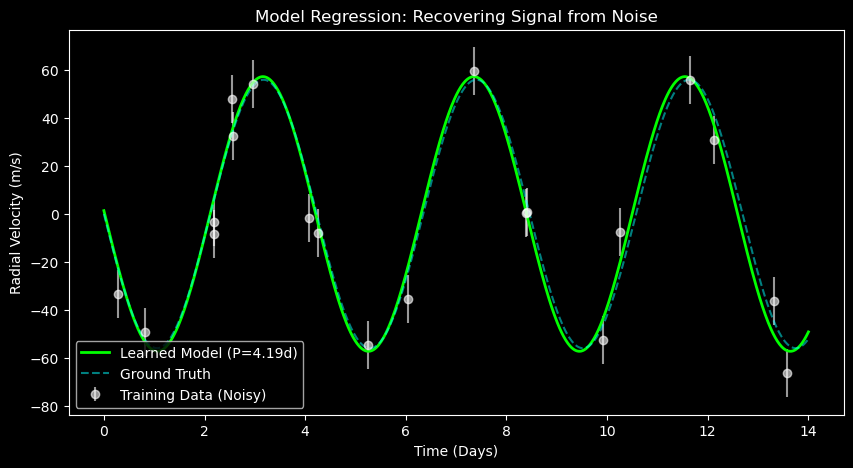

In [12]:
# 5. Visualize the Fit
fig, ax = plt.subplots(figsize=(10, 5))

# The Noisy Data (Training Data)
ax.errorbar(t_obs, v_obs, yerr=noise_level, fmt='o', color='white', alpha=0.6, label='Training Data (Noisy)')

# The Learned Model (Prediction)
t_dense = np.linspace(0, 14, 1000)
v_learned = model_function(t_dense, *best_params) # Unpack params
ax.plot(t_dense, v_learned, color='lime', lw=2, label=f'Learned Model (P={P_fit:.2f}d)')

# The True Model (Ground Truth) - Dashed for comparison
ax.plot(t_model, v_model, color='cyan', linestyle='--', alpha=0.5, label='Ground Truth')

ax.set_title("Model Regression: Recovering Signal from Noise")
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Radial Velocity (m/s)")
ax.legend()
plt.show()

Model Diagnostics
R² Score: 0.9475 (Target: > 0.9)
Reduced Chi-Squared: 0.93 (Target: ~1.0)
Mean Residual Error: -2.17 m/s


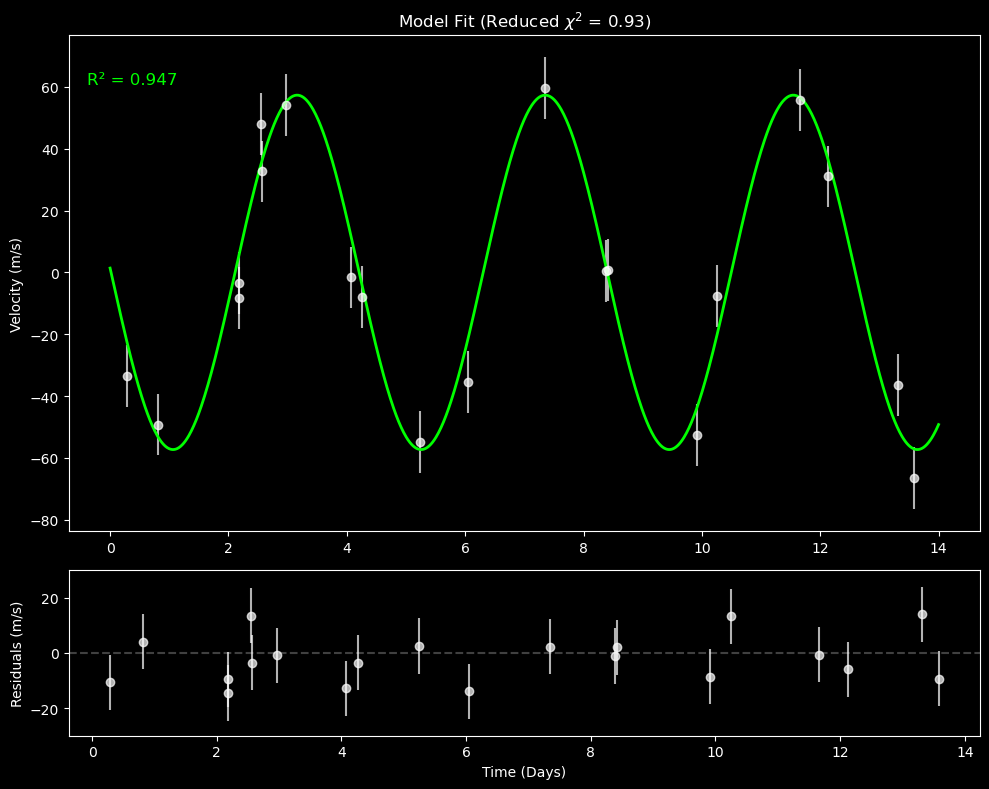

In [13]:
# 6. Statistical Evaluation
from sklearn.metrics import r2_score

# 1. Calculate Predictions on the Training Data
v_pred = model_function(t_obs, *best_params)

# 2. Calculate Residuals (The difference between Data and Model)
residuals = v_obs - v_pred

# 3. Compute Key Metrics
# R-squared: How much of the variance does our model explain? (1.0 is perfect)
r2 = r2_score(v_obs, v_pred)

# Chi-Squared (Goodness of Fit): Sum of squared errors normalized by noise
chi_squared = np.sum(((v_obs - v_pred) / noise_level) ** 2)

# Reduced Chi-Squared: Chi-Squared divided by Degrees of Freedom (N - num_params)
# Rule of Thumb: Should be close to 1.0. 
# > 1.0 means bad model. < 1.0 means we might be overfitting.
dof = len(v_obs) - len(best_params)
chi_reduced = chi_squared / dof

print("Model Diagnostics")
print(f"R² Score: {r2:.4f} (Target: > 0.9)")
print(f"Reduced Chi-Squared: {chi_reduced:.2f} (Target: ~1.0)")
print(f"Mean Residual Error: {np.mean(residuals):.2f} m/s")

# 4. Visualization: The Residuals Plot
# If the model is good, this should look like random noise (no wave patterns!)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: The Fit
ax1.errorbar(t_obs, v_obs, yerr=noise_level, fmt='o', color='white', alpha=0.7)
ax1.plot(t_dense, v_learned, color='lime', lw=2)
ax1.set_ylabel("Velocity (m/s)")
ax1.set_title(f"Model Fit (Reduced $\chi^2$ = {chi_reduced:.2f})")
ax1.text(0.02, 0.9, f"R² = {r2:.3f}", transform=ax1.transAxes, color='lime', fontsize=12)

# Bottom: The Residuals
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.errorbar(t_obs, residuals, yerr=noise_level, fmt='o', color='white', alpha=0.7)
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Residuals (m/s)")
ax2.set_ylim(-3*noise_level, 3*noise_level)

plt.tight_layout()
plt.show()

In [14]:
# 7. Blind Search: The Lomb-Scargle Periodogram
from scipy.signal import lombscargle

In [15]:
# 1. Define a search grid of frequencies
# We search periods from 0.5 days to 10 days
min_period = 0.5
max_period = 10.0
frequency_grid = np.linspace(1/max_period, 1/min_period, 1000) # Angular freqs not needed for scipy implementation usually, but standard LS takes angular.

# Scipy's lombscargle takes angular frequency (radians/s)
angular_freqs = 2 * np.pi * frequency_grid
pgram = lombscargle(t_obs, v_obs, angular_freqs, normalize=True)

In [16]:
# 2. Convert back to Period for plotting
periods = 2 * np.pi / angular_freqs

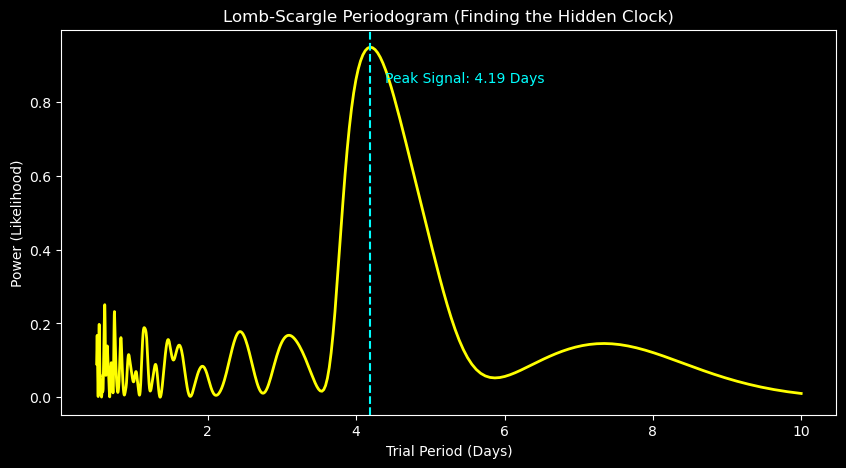

In [19]:
# 3. Visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(periods, pgram, color='yellow', lw=2)

ax.set_title("Lomb-Scargle Periodogram (Finding the Hidden Clock)")
ax.set_xlabel("Trial Period (Days)")
ax.set_ylabel("Power (Likelihood)")
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')

# Highlight the Peak
best_freq_idx = np.argmax(pgram)
best_period = periods[best_freq_idx]
ax.axvline(best_period, color='cyan', linestyle='--')
ax.text(best_period + 0.2, np.max(pgram)*0.9, f"Peak Signal: {best_period:.2f} Days", color='cyan')

plt.show()

In [20]:
# 8. Bayesian Inference (MCMC)
import emcee
import corner

In [21]:
# A. Define the Probability Functions
def log_prior(theta):
    """
    Sets the boundaries for our search. 
    theta = [K, P, phase]
    """
    K, P, phase = theta
    # We assume K and P must be positive. 
    # Phase is usually between -pi and pi, but we'll be lenient.
    if 0 < K < 200 and 0.1 < P < 20 and -10 < phase < 10:
        return 0.0 # Valid region (log(1) = 0)
    return -np.inf # Impossible region (log(0) = -infinity)

def log_likelihood(theta, t, y, yerr):
    """
    Calculates how good the fit is (Gaussian Likelihood).
    """
    K, P, phase = theta
    model = model_function(t, K, P, phase)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, t, y, yerr):
    """
    The Full Bayesian Posterior.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

In [22]:
# B. Setup the Walkers
# We'll start the walkers in a tiny ball around our 'curve_fit' result
# so they don't waste time wandering in empty space.
initial_guess = best_params # From Cell 5
n_walkers = 32
n_dim = 3 # K, P, Phase
pos = initial_guess + 1e-4 * np.random.randn(n_walkers, n_dim)

In [23]:
# C. Run the Sampler
print("Running MCMC...")
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(t_obs, v_obs, noise_level))

# Run for 2000 steps (This might take 10-20 seconds)
sampler.run_mcmc(pos, 2000, progress=True)

Running MCMC...


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 893.36it/s]


State([[ 5.38013018e+01  4.21089331e+00 -2.07592069e-02]
 [ 6.15624648e+01  4.13058009e+00 -1.38698606e-01]
 [ 5.53768353e+01  4.21519749e+00  1.22520972e-02]
 [ 5.69220262e+01  4.16980336e+00 -7.27516370e-03]
 [ 4.94916071e+01  4.22678272e+00 -8.80802181e-02]
 [ 5.13046864e+01  4.26980859e+00  1.91544847e-01]
 [ 5.27635060e+01  4.17065796e+00 -3.74541221e-02]
 [ 5.68374317e+01  4.15546949e+00 -2.02784461e-01]
 [ 5.73906465e+01  4.18255143e+00 -2.87263189e-02]
 [ 5.28145746e+01  4.21177050e+00 -1.56530029e-02]
 [ 5.07815726e+01  4.27818320e+00  1.36245838e-01]
 [ 5.85139750e+01  4.14108273e+00 -1.60802233e-01]
 [ 5.74892109e+01  4.16824832e+00 -1.54695666e-02]
 [ 5.12728820e+01  4.21089615e+00 -3.74439511e-04]
 [ 4.99804186e+01  4.21243832e+00  1.02129827e-02]
 [ 5.31064976e+01  4.18142642e+00 -1.76652191e-02]
 [ 5.60934230e+01  4.11385932e+00 -1.97280801e-01]
 [ 5.07059751e+01  4.25361024e+00  1.41617999e-01]
 [ 5.76062151e+01  4.23572088e+00 -6.11878101e-02]
 [ 5.52977973e+01  4.2462

In [24]:
# D. Analyze the Results
# Discard the first 500 steps ("Burn-in") where the walkers are just getting settled
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(f"Shape of samples: {flat_samples.shape}") # Should be (3200, 3)

Shape of samples: (3200, 3)


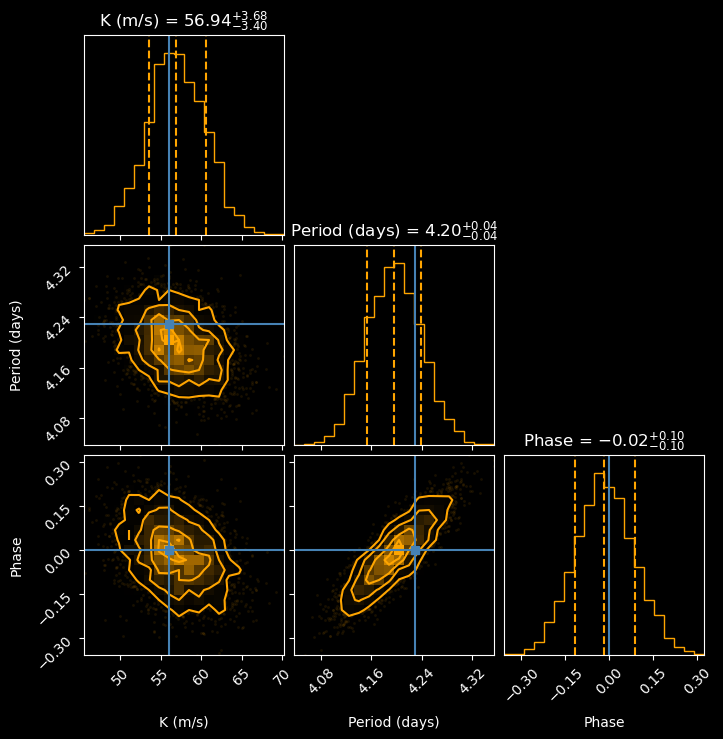

In [25]:
# 9. The Corner Plot
# This plot shows the histograms (probability) for each variable
# and the correlation (blobs) between them.

labels = ["K (m/s)", "Period (days)", "Phase"]
fig = corner.corner(
    flat_samples, 
    labels=labels, 
    truths=[K_star, P_planet, 0.0], # The Ground Truth (Blue Lines)
    truth_color="#4682B4",
    quantiles=[0.16, 0.5, 0.84],    # Show the 1-sigma confidence range
    show_titles=True, 
    title_kwargs={"fontsize": 12},
    color="orange"
)

# Dark mode tweaks for Corner
for ax in fig.get_axes():
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
fig.patch.set_facecolor('black')

plt.show()